<a href="https://colab.research.google.com/github/P-sys/classification-2021/blob/main/%D0%92%D0%9A%D0%A0_%D0%BF%D1%80%D0%B0%D0%BA%D1%82%D0%B8%D0%BA%D0%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Обработка и погодовка данных для дообучения

In [1]:
!pip install pymorphy2

     |████████████████████████████████| 55 kB 2.1 MB/s 
     |████████████████████████████████| 8.2 MB 8.9 MB/s 


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import plot_roc_curve

import re
# import pymorphy2
from collections import Counter
from wordcloud import WordCloud
from tqdm import tqdm

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
pd_from = pd.read_csv('/content/drive/MyDrive/clean_data.csv')

# Обработка

In [ ]:
toxic_comments = pd.read_csv('/content/drive/MyDrive/data_toxic.csv')
toxic_comments.head()

,comment,toxic
0,"Верблюдов-то за что? Дебилы, бл...\n",1.0
1,"Хохлы, это отдушина затюканого россиянина, мол...",1.0
2,Собаке - собачья смерть\n,1.0
3,"Страницу обнови, дебил. Это тоже не оскорблени...",1.0
4,"тебя не убедил 6-страничный пдф в том, что Скр...",1.0


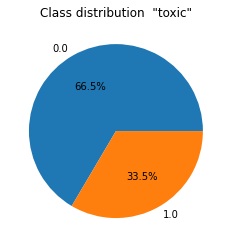

In [ ]:
toxic_comments['toxic'].value_counts().plot(kind='pie', title='Class distribution  "toxic"', autopct='%1.1f%%')
plt.axis('off')
plt.show()

In [ ]:
TOKEN_RE = re.compile(r'[а-яё]+')
russian_stopwords = stopwords.words("russian")
lemmatizer = pymorphy2.MorphAnalyzer()

def tokenize_text(txt, min_lenght_token=2):
    txt = txt.lower()
    all_tokens = TOKEN_RE.findall(txt)
    return [token for token in all_tokens if len(token) >= min_lenght_token]

def remove_stopwords(tokens):
    return list(filter(lambda token: token not in russian_stopwords, tokens))

def lemmatizing(tokens):
    return [lemmatizer.parse(token)[0].normal_form for token in tokens]

def text_cleaning(txt):
    tokens = tokenize_text(txt)
    tokens  = lemmatizing(tokens)
    tokens = remove_stopwords(tokens)
    return ' '.join(tokens)

In [ ]:
tqdm.pandas()

df_token = toxic_comments.copy()
df_token['comment'] = df_token['comment'].progress_apply(text_cleaning)
df_token

100%|██████████| 14412/14412 [01:30<00:00, 158.94it/s]


,comment,toxic
0,верблюд дебил бл,1.0
1,хохол это отдушина затюканый россиянин мол вон...,1.0
2,собака собачий смерть,1.0
3,страница обновить дебил это оскорбление доказа...,1.0
4,убедить страничный пдф скрипаль отравить росси...,1.0
...,...,...
14407,вонючий совковый скот прибежать ныть сторонник...,1.0
14408,любить гоблин тупорылый нибыть продажный сука ...,1.0
14409,посмотреть утомлённый солнце оказаться это хор...,0.0
14410,крымотред нарушать правило раздел немой обсужд...,1.0


In [ ]:
df = df_token.copy()
empty = df[df['comment'] == '']
print('Number of empty texts: ', len(empty))
df = df.drop(empty.index)

Number of empty texts:  12


In [ ]:
print('Number of duplicates:', df.duplicated().sum())

Number of duplicates: 221


In [ ]:
df = df.drop_duplicates()

In [ ]:
comment_duplicated = df[df['comment'].duplicated('last')]

# remove duplicate comments 
df = df.drop_duplicates(subset='comment')
    
print('Number of duplicates:', df.duplicated('comment').sum()) 

Number of duplicates: 0


In [ ]:
clean_text = df.copy()
clean_text.head()

,comment,toxic
0,верблюд дебил бл,1.0
1,хохол это отдушина затюканый россиянин мол вон...,1.0
2,собака собачий смерть,1.0
3,страница обновить дебил это оскорбление доказа...,1.0
4,убедить страничный пдф скрипаль отравить росси...,1.0


In [ ]:
clean_text.to_csv('/content/drive/MyDrive/clean_data.csv', index=False)

In [ ]:
train_com, test_com = train_test_split(clean_text, test_size=0.3)

In [ ]:
train_com, test_com = train_test_split(pd_from, test_size=0.3)

In [ ]:
print(len(train_com))
print(len(test_com))

9893
4241


In [ ]:
train_com.to_csv('/content/drive/MyDrive/train_com.csv', index=False)
test_com.to_csv('/content/drive/MyDrive/test_com.csv', index=False)

# Работа с USE-CNN

In [ ]:
#clean data
train_com = pd.read_csv('/content/drive/MyDrive/train_com.csv')
test_com = pd.read_csv('/content/drive/MyDrive/test_com.csv')

In [4]:
!pip3 install tensorflow_text>=2.0.0rc0

In [5]:
import tensorflow_hub as hub
import tensorflow_text
import tensorflow as tf
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import Dense, Input, BatchNormalization, Dropout, Concatenate
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder-multilingual/3"
embed = hub.KerasLayer(module_url, trainable=True, name='MUSE_embedding')

In [ ]:
def build_model(embed):

  model = Sequential([
                      Input(shape=[], dtype=tf.string),
                      embed,
                      Dense(1, activation='sigmoid')
  ])
  model.compile(Adam(2e-5), loss='binary_crossentropy', metrics=['accuracy'])
  
  return model

In [ ]:
model = build_model(embed)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MUSE_embedding (KerasLayer)  (None, 512)              68927232  
                                                                 
 dense (Dense)               (None, 1)                 513       
                                                                 
Total params: 68,927,745
Trainable params: 68,927,745
Non-trainable params: 0
_________________________________________________________________


In [ ]:
checkpoint = ModelCheckpoint('model.h5', monitor='val_accuracy', save_best_only=True)

train_history = model.fit(
    train_com['comment'].values, train_com['toxic'].values,
    validation_split=0.2,
    epochs=4,
    callbacks=[checkpoint],
    batch_size=32
)

Epoch 1/4
248/248 [==============================] - 72s 126ms/step - loss: 0.5648 - accuracy: 0.7388 - val_loss: 0.4315 - val_accuracy: 0.8843
Epoch 2/4
248/248 [==============================] - 33s 132ms/step - loss: 0.3920 - accuracy: 0.8822 - val_loss: 0.3532 - val_accuracy: 0.8934
Epoch 3/4
248/248 [==============================] - 32s 130ms/step - loss: 0.3330 - accuracy: 0.9066 - val_loss: 0.3313 - val_accuracy: 0.8994
Epoch 4/4
248/248 [==============================] - 30s 122ms/step - loss: 0.2959 - accuracy: 0.9265 - val_loss: 0.3188 - val_accuracy: 0.9015


In [ ]:
model.load_weights('model.h5')
test_pred = model.predict(test_com['comment'].values)

In [ ]:
test_com['pred'] = test_pred.round().astype(int)

In [ ]:
test_com[10:50]

In [ ]:
print(classification_report(test_com['toxic'].values, test_com['pred'].values))

# Работа с USE-TRANS

In [ ]:
module_url_trans = 'https://tfhub.dev/google/universal-sentence-encoder-multilingual-large/3'
embed_trans = hub.KerasLayer(module_url_trans, trainable=True, name='MUSE_embedding')

In [ ]:
def build_model_tr(embed):

  model = Sequential([
                      Input(shape=[], dtype=tf.string),
                      embed,
                      Dense(1, activation='sigmoid')
  ])
  model.compile(Adam(2e-5), loss='binary_crossentropy', metrics=['accuracy'])
  
  return model

In [ ]:
model_trans = build_model_tr(embed_trans)
model_trans.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MUSE_embedding (KerasLayer)  (None, 512)              85213184  
                                                                 
 dense (Dense)               (None, 1)                 513       
                                                                 
Total params: 85,213,697
Trainable params: 85,213,697
Non-trainable params: 0
_________________________________________________________________


In [ ]:
checkpoint_trans = ModelCheckpoint('model_trans.h5', monitor='val_accuracy', save_best_only=True)

train_history_trans = model_trans.fit(
    train_com['comment'].values, train_com['toxic'].values,
    validation_split=0.30,
    epochs=4,
    callbacks=[checkpoint_trans],
    batch_size=16
)

Epoch 1/4


186/433 [===========>..................] - ETA: 12:13 - loss: 0.5564 - accuracy: 0.7581

In [ ]:
model_trans.load_weights('model_trans.h5')
test_pred_trans = model_trans.predict(test_com['comment'].values)

In [ ]:
test_com['pred_trans'] = test_pred_trans.round().astype(int)

In [ ]:
test_com[10:30]

In [ ]:
print(classification_report(test_com['toxic'].values, test_com['pred_trans'].values))

# BERT/mBERT/XMLRoBERTa

In [3]:
!pip install transformers

     |████████████████████████████████| 4.0 MB 4.0 MB/s 
     |████████████████████████████████| 77 kB 6.1 MB/s 
     |████████████████████████████████| 596 kB 41.2 MB/s 
     |████████████████████████████████| 6.5 MB 12.8 MB/s 
     |████████████████████████████████| 895 kB 37.8 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [8]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from transformers import BertTokenizer
from transformers import AdamW, BertForSequenceClassification
import io
from sklearn.metrics import accuracy_score

In [9]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# model = AutoModel.from_pretrained("DeepPavlov/rubert-base-cased")

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if device == torch.device('cpu'):
  print('Using CPU')
else:
  print('Using GPU')

Using GPU


In [22]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in pd_from['comment'].values:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 200,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        truncation=True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
# fort = np.array([[int(i), int(not(i))] for i in pd_from['toxic']])
labels = torch.tensor(pd_from['toxic'])

# Print sentence 0, now as a list of IDs.
print('Original: ', pd_from['comment'][0])
print('Token IDs:', input_ids[0])

Original:  верблюд дебил бл
Token IDs: tensor([  101,  1182, 15290, 16856, 29740, 29436, 29757, 29742,  1184, 15290,
        29740, 10325, 29436,  1181, 29436,   102,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,    

In [23]:
dataset = TensorDataset(input_ids, attention_masks, labels)

In [24]:
train_bert, test_bert = train_test_split(dataset, test_size=0.2)

In [25]:
train_dataset, val_dataset = train_test_split(train_bert, test_size=0.2)

In [26]:
# from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
batch_size = 32

train_dataloader = DataLoader(
    train_dataset,
    sampler = RandomSampler(train_dataset),
    batch_size = batch_size
)

validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [27]:
# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
# model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [28]:
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [29]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

In [30]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 2

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [31]:
import random
import time
import datetime
from IPython.display import clear_output

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [32]:
# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0
    model.train()
    train_loss_set = []

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))
 
        # b_input_ids = batch[0].to(device)
        # b_input_mask = batch[1].to(device)
        # b_labels = batch[2].to(device)

        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        print(b_labels.size())

        model.zero_grad()        
        loss = model(b_input_ids, 
                     token_type_ids=None, 
                     attention_mask=b_input_mask, 
                     labels=b_labels)
        
        # print(g[0])
        total_train_loss += loss[0].item()

        #backward pass
        loss[0].backward()

        # Clip the norm of the gradients to 1.0
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()

        # Update the learning rate.
        scheduler.step()

        train_loss_set.append(loss[0].item())

        clear_output(True)
        plt.plot(train_loss_set)
        plt.title("Training loss")
        plt.xlabel("Batch")
        plt.ylabel("Loss")
        plt.show()

    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # b_input_ids = batch[0].to(device)
        # b_input_mask = batch[1].to(device)
        # b_labels = batch[2].to(device)


        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            result = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
        loss = result.loss
        logits = result.logits
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 2 ========
Training...
torch.Size([32])


RuntimeError: ignored

In [ ]:
# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        loss, logits = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            (loss, logits) = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

# first take

In [7]:
pd_from['for_bert'] = "[CLS] " + pd_from['comment'] + " [SEP]"

In [51]:
max = -1
fg = 0

for i in range(len(pd_from['for_bert'].values)):
  k = len(pd_from['for_bert'][i].split())
  if k > max:
    max = k
    fg = i

max, fg

(686, 2031)

In [9]:
def get_ids(text): # на вход столбец дата фрейма
  tok_text = [tokenizer.tokenize(sent) for sent in text.values]
  input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tok_text]
  input_ids = pad_sequences(
      input_ids,
      maxlen = 250,
      dtype="long",
      truncating="post",
      padding="post"
  )
  return input_ids

In [10]:
token_ids = get_ids(train_bert['for_bert'])

In [11]:
attention_masks = [[float(i>0) for i in seq] for seq in token_ids]

In [12]:
train_ids, valid_ids, train_labels, valid_labels = train_test_split(
    token_ids, train_bert['toxic'].values,
    random_state=42,
    test_size=0.1
) 

train_masks, valid_masks = train_test_split(
    attention_masks,
    random_state=42,
    test_size=0.1
) 

In [13]:
train_ids = torch.tensor(train_ids)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)

In [14]:
valid_ids = torch.tensor(valid_ids)
valid_labels = torch.tensor(valid_labels)
valid_masks = torch.tensor(valid_masks)

In [34]:
train_data = TensorDataset(train_ids, train_masks, train_labels)
train_dataloader = DataLoader(
    train_data,
    sampler=RandomSampler(train_data),
    batch_size=8
)

NameError: ignored

In [16]:
validation_data = TensorDataset(valid_ids, valid_masks, valid_labels)
validation_dataloader = DataLoader(
    validation_data,
    sampler=RandomSampler(validation_data),
    batch_size=8
)

In [17]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased")
# DeepPavlov/rubert-base-cased

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
model.to(device)

In [19]:
# param_optimizer = list(model.named_parameters())
# no_decay = ['bias', 'gamma', 'beta']
# optimizer_grouped_parameters = [
#                                 {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
#                                  'weight_decay_rate': 0.01},
#                                 {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
#                                  'weight_decay_rate': 0.0}
# ]

optimizer = AdamW(model.parameters(), lr=2e-5)

In [28]:
torch.tensor([1]).unsqueeze(0)

tensor([[1]])

In [ ]:
import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [ ]:
# from IPython.display import clear_output

# train_loss_set = []
# train_loss = 0

# model.train()

# for step, batch in enumerate(train_dataloader):
#   batch = tuple(t.to(device) for t in batch)

#   b_input_ids, b_input_mask, b_labels = batch

#   optimizer.zero_grad()
#   loss, _ = model(b_input_ids, token_type_ids=None, attention_masks=b_input_mask, labels=b_labels)
#   train_loss_set.append(loss[0].items())

#   loss[0].backward()
#   optimizer.step()

#   train_loss += loss[0].item()

#   clear_output(True)
#   plt.plot(train_loss_set)
#   plt.title("Training loss")
#   plt.xlabel("Batch")
#   plt.ylabels("Loss")
#   plt.show()

# print("Train loss: {0:.5f}".format(train_loss))

# model.eval()

# val_loss = 0
# total_eval_accuracy = 0

# valid_preds, valid_labels = [], []

# for batch in validation_dataloader:

#   batch = tuple(t.to(device) for t in batch)
#   b_input_ids, b_input_mask, b_labels = batch

#   with torch.no_grad():
#     loss, logits = model(b_input_ids, token_type_ids=None, attention_masks=b_input_mask, labels=b_labels)

#   val_loss += loss[0].item()
#   logits = logits[0].datach().cpu().numpy()
#   label_ids = b_labels.to('cpu').numpy()


#   batch_preds = np.argmax(logits, axis=1)
#   total_eval_accuracy += flat_accuracy(logits, label_ids)